In [1]:
EXPORT = False

In [2]:
import IPython
from pathlib import Path
import pandas as pd
csv_files = list((Path().glob('*.csv')))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    split = str(file).split('_')
    architecture = split[0]
    tokenizer = split[-2]
    random_weights = False
    if('RANDOM' in split):
        random_weights = True
        
    df.insert(0, 'random_weights',random_weights)
    df.insert(0, 'tokenizer',tokenizer)
    df.insert(0, 'architecture',architecture)
    
    df['file_name'] = file
    dfs.append(df)
    # print(df.head())

main_df = pd.concat(dfs, ignore_index=True)

#### The whole table to csv

In [3]:
# main_df.to_csv('all_outputs.csv')

# Exploration

In [4]:
from genomic_benchmarks.data_check.info import list_datasets

/opt/conda/envs/cdna_env/lib/python3.8/site-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
main_df.keys()

Index(['architecture', 'tokenizer', 'random_weights', 'dataset', 'test_acc',
       'test_f1', 'test_loss', 'test_precision', 'test_recall',
       'test_auroc_macro', 'test_auroc_weighted', 'test_pr_auc',
       'min_valid_loss_epoch', 'min_valid_loss_log', 'file_name'],
      dtype='object')

In [6]:
all_datasets = list_datasets()
all_datasets.remove('dummy_mouse_enhancers_ensembl')
all_datasets

['drosophila_enhancers_stark',
 'human_ensembl_regulatory',
 'human_enhancers_cohn',
 'human_enhancers_ensembl',
 'human_nontata_promoters',
 'demo_coding_vs_intergenomic_seqs',
 'demo_human_or_worm',
 'human_ocr_ensembl']

In [7]:
categories = ['dataset', 'architecture', 'tokenizer', 'random_weights']
exp_options = {}
for category in categories:
    exp_options[category] = []

for category in categories:
    exp_options[category].extend(main_df[category].unique())
exp_options

{'dataset': ['demo_coding_vs_intergenomic_seqs',
  'demo_human_or_worm',
  'human_enhancers_cohn',
  'human_enhancers_ensembl',
  'human_nontata_promoters',
  'human_ocr_ensembl',
  'drosophila_enhancers_stark'],
 'architecture': ['BERT', 'DEBERTA'],
 'tokenizer': ['DNABERTtokenizer',
  'Sentencepiece10tokenizer',
  'Sentencepiece30tokenizer',
  'Kmer8tokenizer',
  'Kmer7tokenizer'],
 'random_weights': [False, True]}

# Visualise

In [8]:
def style_dataframe(
    df, 
    df_keys = ['architecture','dataset','tokenizer','random_weights','test_acc', 'test_f1', 'test_auroc_weighted','test_pr_auc'], 
    keys_to_style = ['test_acc', 'test_f1', 'test_auroc_weighted','test_pr_auc'],
    sort_by = 'tokenizer'
):
    # .style.bar()\
    
    df = df[df_keys]\
    .sort_values(sort_by)\
    .style\
    .hide(axis='index')\
    .format({"dataset": lambda x:x.lower()}, precision=2)\
    .background_gradient(subset=keys_to_style, cmap='Oranges', axis=0)\
    .applymap(lambda x: '' if x==x else 'background-color: white')\
    .applymap(lambda x: 'color: black' if pd.isna(x) else '')\

    
    
    
    return df

In [9]:
CHOOSEN_METRIC = 'test_acc'

CHOOSEN_METRIC_PRETRAINED = CHOOSEN_METRIC + '_pretrained'
CHOOSEN_METRIC_DIFF = CHOOSEN_METRIC + '_diff'
choosen_columns = ['architecture', 'tokenizer', 'dataset', CHOOSEN_METRIC]

metrics_df = main_df.copy(deep = True)
metrics_df[choosen_columns]
compared = pd.DataFrame(columns = [*choosen_columns, CHOOSEN_METRIC_PRETRAINED, CHOOSEN_METRIC_DIFF])

for dataset in exp_options['dataset']:
    for architecture in exp_options['architecture']:
        for tokenizer in exp_options['tokenizer']:
            row = metrics_df[(metrics_df['dataset'] == dataset) & (metrics_df['architecture'] == architecture) & (metrics_df['tokenizer'] == tokenizer) & (metrics_df['random_weights'] == True)][choosen_columns].copy(deep=True)
            metrics_random = row[CHOOSEN_METRIC].mean()
            metrics_pretrained = metrics_df\
                [(metrics_df['dataset'] == dataset) & (metrics_df['architecture'] == architecture) & (metrics_df['tokenizer'] == tokenizer) & (metrics_df['random_weights'] == False)]\
                [CHOOSEN_METRIC].mean()
            
            if((metrics_pretrained) and (metrics_random)):
                metrics_diff = metrics_pretrained - metrics_random 
                
                row[CHOOSEN_METRIC] = metrics_random * 100
                row[CHOOSEN_METRIC_PRETRAINED] = metrics_pretrained * 100
                row[CHOOSEN_METRIC_DIFF] = metrics_diff * 100
            else:
                try:
                    row[CHOOSEN_METRIC] = metrics_random * 100
                    row[CHOOSEN_METRIC_PRETRAINED] = 'nan'
                    row[CHOOSEN_METRIC_DIFF] = 'nan'
                except:
                    print('except')
                    print(metrics_random)
                    row[CHOOSEN_METRIC_PRETRAINED] = 'nan'
                    row[CHOOSEN_METRIC_DIFF] = 'nan'
            compared = pd.concat([compared, row])
            
            
compared = compared.round(decimals=4)
compared = compared[~ compared.duplicated(['test_acc'], keep = 'first')]

In [10]:
compared

,architecture,tokenizer,dataset,test_acc,test_acc_pretrained,test_acc_diff
22,BERT,DNABERTtokenizer,demo_coding_vs_intergenomic_seqs,90.0467,92.4600,2.4133
117,BERT,Sentencepiece10tokenizer,demo_coding_vs_intergenomic_seqs,87.6520,NaN,NaN
132,BERT,Sentencepiece30tokenizer,demo_coding_vs_intergenomic_seqs,87.2240,NaN,NaN
152,BERT,Kmer8tokenizer,demo_coding_vs_intergenomic_seqs,89.8880,NaN,NaN
65,BERT,Kmer7tokenizer,demo_coding_vs_intergenomic_seqs,90.0180,NaN,NaN
...,...,...,...,...,...,...
20,DEBERTA,DNABERTtokenizer,drosophila_enhancers_stark,55.9827,68.6705,12.6879
13,DEBERTA,Sentencepiece10tokenizer,drosophila_enhancers_stark,64.6821,73.7572,9.0751
61,DEBERTA,Sentencepiece30tokenizer,drosophila_enhancers_stark,62.3988,71.2717,8.8728
151,DEBERTA,Kmer8tokenizer,drosophila_enhancers_stark,58.2081,71.0405,12.8324


### BERT, DEBERTA, all datasets - random X pretrained

In [11]:
styled_tokenizers = []
for dataset in exp_options['dataset']:
    styled_tokenizers.append(style_dataframe(
        df = compared[(compared[CHOOSEN_METRIC_PRETRAINED].notnull()) & (compared['dataset'] == dataset)],
        df_keys = [*choosen_columns, CHOOSEN_METRIC_PRETRAINED, CHOOSEN_METRIC_DIFF],
        keys_to_style = [CHOOSEN_METRIC_DIFF],
        sort_by = 'tokenizer'
    ))
    
if(EXPORT):
    for idx, x in enumerate(styled_tokenizers):
        x.to_excel('both_model_random_weights' + str(idx) + '.xlsx', engine='openpyxl') 


In [12]:
styled_tokenizers[0]

architecture,tokenizer,dataset,test_acc,test_acc_pretrained,test_acc_diff
BERT,DNABERTtokenizer,demo_coding_vs_intergenomic_seqs,90.05,92.46,2.41
DEBERTA,DNABERTtokenizer,demo_coding_vs_intergenomic_seqs,90.12,91.83,1.71
DEBERTA,Kmer7tokenizer,demo_coding_vs_intergenomic_seqs,90.10,91.22,1.12
DEBERTA,Kmer8tokenizer,demo_coding_vs_intergenomic_seqs,89.53,91.03,1.49
DEBERTA,Sentencepiece10tokenizer,demo_coding_vs_intergenomic_seqs,87.94,91.01,3.07
DEBERTA,Sentencepiece30tokenizer,demo_coding_vs_intergenomic_seqs,86.73,90.59,3.86


In [13]:
styled_tokenizers[1]

architecture,tokenizer,dataset,test_acc,test_acc_pretrained,test_acc_diff
BERT,DNABERTtokenizer,demo_human_or_worm,95.37,96.58,1.21
DEBERTA,DNABERTtokenizer,demo_human_or_worm,95.46,95.93,0.47
DEBERTA,Kmer7tokenizer,demo_human_or_worm,95.54,95.86,0.32
DEBERTA,Kmer8tokenizer,demo_human_or_worm,94.83,95.82,0.99
DEBERTA,Sentencepiece10tokenizer,demo_human_or_worm,93.12,95.15,2.04
DEBERTA,Sentencepiece30tokenizer,demo_human_or_worm,92.52,95.52,3.01


In [14]:
styled_tokenizers[2]

architecture,tokenizer,dataset,test_acc,test_acc_pretrained,test_acc_diff
BERT,DNABERTtokenizer,human_enhancers_cohn,72.72,74.19,1.48
DEBERTA,DNABERTtokenizer,human_enhancers_cohn,73.03,73.14,0.12
DEBERTA,Kmer7tokenizer,human_enhancers_cohn,72.09,72.91,0.82
DEBERTA,Kmer8tokenizer,human_enhancers_cohn,70.60,72.45,1.85
DEBERTA,Sentencepiece10tokenizer,human_enhancers_cohn,69.76,73.26,3.50
DEBERTA,Sentencepiece30tokenizer,human_enhancers_cohn,69.57,73.76,4.18


In [15]:
styled_tokenizers[3]

architecture,tokenizer,dataset,test_acc,test_acc_pretrained,test_acc_diff
BERT,DNABERTtokenizer,human_enhancers_ensembl,80.17,86.61,6.44
DEBERTA,DNABERTtokenizer,human_enhancers_ensembl,81.29,86.26,4.97
DEBERTA,Kmer7tokenizer,human_enhancers_ensembl,79.52,87.09,7.57
DEBERTA,Kmer8tokenizer,human_enhancers_ensembl,79.37,82.98,3.61
DEBERTA,Sentencepiece10tokenizer,human_enhancers_ensembl,78.56,85.20,6.64
DEBERTA,Sentencepiece30tokenizer,human_enhancers_ensembl,78.84,84.03,5.19


In [16]:
styled_tokenizers[4]

architecture,tokenizer,dataset,test_acc,test_acc_pretrained,test_acc_diff
BERT,DNABERTtokenizer,human_nontata_promoters,82.65,82.90,0.24
DEBERTA,DNABERTtokenizer,human_nontata_promoters,83.55,90.10,6.55
DEBERTA,Kmer7tokenizer,human_nontata_promoters,87.10,90.72,3.62
DEBERTA,Kmer8tokenizer,human_nontata_promoters,89.25,93.07,3.81
DEBERTA,Sentencepiece10tokenizer,human_nontata_promoters,83.94,86.67,2.73
DEBERTA,Sentencepiece30tokenizer,human_nontata_promoters,84.43,86.96,2.53


In [17]:
styled_tokenizers[5]

architecture,tokenizer,dataset,test_acc,test_acc_pretrained,test_acc_diff
BERT,DNABERTtokenizer,human_ocr_ensembl,71.46,76.85,5.39
DEBERTA,DNABERTtokenizer,human_ocr_ensembl,71.82,77.06,5.24
DEBERTA,Kmer7tokenizer,human_ocr_ensembl,72.38,77.11,4.74
DEBERTA,Kmer8tokenizer,human_ocr_ensembl,71.91,75.00,3.09
DEBERTA,Sentencepiece10tokenizer,human_ocr_ensembl,67.95,73.88,5.93
DEBERTA,Sentencepiece30tokenizer,human_ocr_ensembl,65.53,73.08,7.55


In [18]:
styled_tokenizers[6]

architecture,tokenizer,dataset,test_acc,test_acc_pretrained,test_acc_diff
BERT,DNABERTtokenizer,drosophila_enhancers_stark,56.39,70.35,13.96
DEBERTA,DNABERTtokenizer,drosophila_enhancers_stark,55.98,68.67,12.69
DEBERTA,Kmer7tokenizer,drosophila_enhancers_stark,55.03,70.64,15.61
DEBERTA,Kmer8tokenizer,drosophila_enhancers_stark,58.21,71.04,12.83
DEBERTA,Sentencepiece10tokenizer,drosophila_enhancers_stark,64.68,73.76,9.08
DEBERTA,Sentencepiece30tokenizer,drosophila_enhancers_stark,62.40,71.27,8.87


### BERT - random X pretrained

In [19]:
style_dataframe(
    compared[(compared[CHOOSEN_METRIC_PRETRAINED].notnull()) & (compared['architecture'] == 'BERT')],
    [*choosen_columns, CHOOSEN_METRIC_PRETRAINED, CHOOSEN_METRIC_DIFF],
    [CHOOSEN_METRIC_DIFF],
    sort_by = 'dataset'
)

architecture,tokenizer,dataset,test_acc,test_acc_pretrained,test_acc_diff
BERT,DNABERTtokenizer,demo_coding_vs_intergenomic_seqs,90.05,92.46,2.41
BERT,DNABERTtokenizer,demo_human_or_worm,95.37,96.58,1.21
BERT,DNABERTtokenizer,drosophila_enhancers_stark,56.39,70.35,13.96
BERT,DNABERTtokenizer,human_enhancers_cohn,72.72,74.19,1.48
BERT,DNABERTtokenizer,human_enhancers_ensembl,80.17,86.61,6.44
BERT,DNABERTtokenizer,human_nontata_promoters,82.65,82.90,0.24
BERT,DNABERTtokenizer,human_ocr_ensembl,71.46,76.85,5.39


### Average gain from pretraining

### Compare and rank tokenizers

In [20]:

### Returns 2 dataframes: tokenizers metric comparison and ranks
# it is a dirty function "hiddenly" using some variables from the code above

def compare_tokenizers(rank_architecture = 'both', choosen_metric = CHOOSEN_METRIC):
    # reuses the CHOOSEN_METRIC from analyses above
    # also reuses the dataframe named "compared" from analyses above

    # Choose if you want pretrained or random metrics
    CHOOSEN_PARAMETER = choosen_metric # or CHOOSEN_METRIC_PRETRAINED or CHOOSEN_METRIC_DIFF

    choosen_datasets = exp_options['dataset']
    choosen_columns = ['architecture', 'tokenizer', 'dataset', CHOOSEN_PARAMETER]

    metrics_df = compared.copy(deep = True)
    metrics_df[choosen_columns]
    result_df = pd.DataFrame(columns = ['architecture', 'tokenizer', *choosen_datasets])

    for architecture in exp_options['architecture']:
        for tokenizer in exp_options['tokenizer']:
            new_row = [architecture, tokenizer]
            row = compared\
                [(metrics_df['architecture'] == architecture) & (metrics_df['tokenizer'] == tokenizer)]\
                [choosen_columns]

            for dataset in exp_options['dataset']:
                if(dataset == 'drosophila_enhancers_stark'):
                    value = row[row['dataset'] == dataset][CHOOSEN_PARAMETER].max()
                else:
                    value = row[row['dataset'] == dataset][CHOOSEN_PARAMETER].mean()
                new_row.append(value)

            result_df = pd.concat([result_df, pd.DataFrame([new_row], columns = result_df.columns)], ignore_index=True)


    result_df[choosen_datasets] = result_df[choosen_datasets].astype(float).round(2)
    
    ### Ranking tokenizers
    choosen_datasets_rank_names = []
    for dataset in choosen_datasets:
        choosen_datasets_rank_names.append(dataset + '_rank')
    print(choosen_datasets_rank_names)

    if (rank_architecture == 'both'):
        ranks_df = result_df.copy(deep=True)
    else:
        ranks_df = result_df[result_df['architecture'] == rank_architecture].copy(deep=True)

    for dataset in choosen_datasets:
        ranks_df[dataset + '_rank'] = ranks_df[dataset].rank(ascending = False)
    ranks_df = ranks_df[['architecture', 'tokenizer', *choosen_datasets_rank_names]]
    
    #### Sum ranks
    ranks_df['rank_sum'] = ranks_df[choosen_datasets_rank_names].sum(axis=1)
    result_df['rank_sum'] = ranks_df[choosen_datasets_rank_names].sum(axis=1)
    
    ##### Sum ranks without drosophila
    choosen_datasets_rank_names.remove('drosophila_enhancers_stark_rank')
    ranks_df['rank_sum_without_drosophila'] = ranks_df[choosen_datasets_rank_names].sum(axis=1)
    choosen_datasets_rank_names.append('drosophila_enhancers_stark_rank')
    
    #### Sum metric
    ranks_df[choosen_metric + '_sum'] = result_df[choosen_datasets].sum(axis=1)
    result_df[choosen_metric + '_sum'] = result_df[choosen_datasets].sum(axis=1)
    
    ##### Sum ranks without drosophila
    choosen_datasets.remove('drosophila_enhancers_stark')
    ranks_df[choosen_metric + '_sum_without_drosophila'] = result_df[choosen_datasets].sum(axis=1)
    choosen_datasets.append('drosophila_enhancers_stark')
    
    ##### Add model - tokenizer column for plotting
    methods = []
    for index, row in ranks_df.iterrows():
        methods.append(row['architecture'] + '_' + row['tokenizer'].replace('tokenizer',''))
    ranks_df['architecture_tokenizer'] = methods
        
    methods = []
    for index, row in result_df.iterrows():
        methods.append(row['architecture'] + '_' + row['tokenizer'].replace('tokenizer',''))
    result_df['architecture_tokenizer'] = methods
    
    ##### Reorden columns
    ranks_df = ranks_df[[
        'architecture',
        'tokenizer',
        'rank_sum',
        'rank_sum_without_drosophila',
        choosen_metric + '_sum',
        choosen_metric + '_sum_without_drosophila',
        'demo_coding_vs_intergenomic_seqs_rank',
        'demo_human_or_worm_rank',
        'human_enhancers_cohn_rank',
        'human_enhancers_ensembl_rank',
        'human_nontata_promoters_rank',
        'human_ocr_ensembl_rank',
        'drosophila_enhancers_stark_rank',
        'architecture_tokenizer',
    ]]
    
    
    ### Returns 2 dataframes: tokenizers metric comparison and ranks
    return result_df, ranks_df, choosen_datasets_rank_names

In [21]:
def style_ranks(df, sort_by = 'rank_sum'):
    columns_to_style = df.columns.tolist()
    columns_to_style.remove('architecture')
    columns_to_style.remove('tokenizer')
    if 'architecture_tokenizer' in columns_to_style:
        columns_to_style.remove('architecture_tokenizer')
        print(columns_to_style)



    styled_df = style_dataframe(
        df = df,
        df_keys = df.columns.tolist(),
        keys_to_style = columns_to_style,
        sort_by = sort_by
    )
    return styled_df

#### Metrics for randomized weights

In [22]:
results, ranks_deberta, choosen_datasets_rank_names = compare_tokenizers(rank_architecture = 'DEBERTA', choosen_metric = CHOOSEN_METRIC)

['demo_coding_vs_intergenomic_seqs_rank', 'demo_human_or_worm_rank', 'human_enhancers_cohn_rank', 'human_enhancers_ensembl_rank', 'human_nontata_promoters_rank', 'human_ocr_ensembl_rank', 'drosophila_enhancers_stark_rank']


In [23]:
style_ranks(ranks_deberta)

['rank_sum', 'rank_sum_without_drosophila', 'test_acc_sum', 'test_acc_sum_without_drosophila', 'demo_coding_vs_intergenomic_seqs_rank', 'demo_human_or_worm_rank', 'human_enhancers_cohn_rank', 'human_enhancers_ensembl_rank', 'human_nontata_promoters_rank', 'human_ocr_ensembl_rank', 'drosophila_enhancers_stark_rank']


architecture,tokenizer,rank_sum,rank_sum_without_drosophila,test_acc_sum,test_acc_sum_without_drosophila,demo_coding_vs_intergenomic_seqs_rank,demo_human_or_worm_rank,human_enhancers_cohn_rank,human_enhancers_ensembl_rank,human_nontata_promoters_rank,human_ocr_ensembl_rank,drosophila_enhancers_stark_rank,architecture_tokenizer
DEBERTA,Kmer7tokenizer,15.00,10.00,551.76,496.73,2.00,1.00,2.00,2.00,2.00,1.00,5.00,DEBERTA_Kmer7
DEBERTA,DNABERTtokenizer,17.00,13.00,551.25,495.27,1.00,2.00,1.00,1.00,5.00,3.00,4.00,DEBERTA_DNABERT
DEBERTA,Kmer8tokenizer,18.00,15.00,553.70,495.49,3.00,3.00,3.00,3.00,1.00,2.00,3.00,DEBERTA_Kmer8
DEBERTA,Sentencepiece10tokenizer,26.00,25.00,545.95,481.27,4.00,4.00,4.00,5.00,4.00,4.00,1.00,DEBERTA_Sentencepiece10
DEBERTA,Sentencepiece30tokenizer,29.00,27.00,540.02,477.62,5.00,5.00,5.00,4.00,3.00,5.00,2.00,DEBERTA_Sentencepiece30


In [24]:
results, ranks_bert, choosen_datasets_rank_names = compare_tokenizers(rank_architecture = 'BERT', choosen_metric = CHOOSEN_METRIC)

['demo_coding_vs_intergenomic_seqs_rank', 'demo_human_or_worm_rank', 'human_enhancers_cohn_rank', 'human_enhancers_ensembl_rank', 'human_nontata_promoters_rank', 'human_ocr_ensembl_rank', 'drosophila_enhancers_stark_rank']


In [25]:
style_ranks(ranks_bert)

['rank_sum', 'rank_sum_without_drosophila', 'test_acc_sum', 'test_acc_sum_without_drosophila', 'demo_coding_vs_intergenomic_seqs_rank', 'demo_human_or_worm_rank', 'human_enhancers_cohn_rank', 'human_enhancers_ensembl_rank', 'human_nontata_promoters_rank', 'human_ocr_ensembl_rank', 'drosophila_enhancers_stark_rank']


architecture,tokenizer,rank_sum,rank_sum_without_drosophila,test_acc_sum,test_acc_sum_without_drosophila,demo_coding_vs_intergenomic_seqs_rank,demo_human_or_worm_rank,human_enhancers_cohn_rank,human_enhancers_ensembl_rank,human_nontata_promoters_rank,human_ocr_ensembl_rank,drosophila_enhancers_stark_rank,architecture_tokenizer
BERT,Kmer7tokenizer,13.00,9.00,549.47,496.55,2.00,1.00,1.00,2.00,2.00,1.00,4.00,BERT_Kmer7
BERT,DNABERTtokenizer,14.00,13.00,548.81,492.42,1.00,2.00,2.00,1.00,4.00,3.00,1.00,BERT_DNABERT
BERT,Kmer8tokenizer,24.00,21.00,539.87,485.97,3.00,3.00,5.00,3.00,5.00,2.00,3.00,BERT_Kmer8
BERT,Sentencepiece10tokenizer,27.00,22.00,534.51,481.74,4.00,4.00,3.00,4.00,3.00,4.00,5.00,BERT_Sentencepiece10
BERT,Sentencepiece30tokenizer,27.00,25.00,535.99,479.86,5.00,5.00,4.00,5.00,1.00,5.00,2.00,BERT_Sentencepiece30


In [26]:
results, ranks_both, choosen_datasets_rank_names = compare_tokenizers(choosen_metric = CHOOSEN_METRIC)

['demo_coding_vs_intergenomic_seqs_rank', 'demo_human_or_worm_rank', 'human_enhancers_cohn_rank', 'human_enhancers_ensembl_rank', 'human_nontata_promoters_rank', 'human_ocr_ensembl_rank', 'drosophila_enhancers_stark_rank']


In [27]:
if(EXPORT):
    style_ranks(results, sort_by='tokenizer').to_excel('both_model_random_weights.xlsx', engine='openpyxl')
style_ranks(results, sort_by='tokenizer')

['demo_coding_vs_intergenomic_seqs', 'demo_human_or_worm', 'human_enhancers_cohn', 'human_enhancers_ensembl', 'human_nontata_promoters', 'human_ocr_ensembl', 'drosophila_enhancers_stark', 'rank_sum', 'test_acc_sum']


architecture,tokenizer,demo_coding_vs_intergenomic_seqs,demo_human_or_worm,human_enhancers_cohn,human_enhancers_ensembl,human_nontata_promoters,human_ocr_ensembl,drosophila_enhancers_stark,rank_sum,test_acc_sum,architecture_tokenizer
BERT,DNABERTtokenizer,90.05,95.37,72.72,80.17,82.65,71.46,56.39,31.00,548.81,BERT_DNABERT
DEBERTA,DNABERTtokenizer,90.12,95.46,73.03,81.29,83.55,71.82,55.98,25.00,551.25,DEBERTA_DNABERT
BERT,Kmer7tokenizer,90.02,95.57,72.80,79.64,85.84,72.68,52.92,24.00,549.47,BERT_Kmer7
DEBERTA,Kmer7tokenizer,90.10,95.54,72.09,79.52,87.10,72.38,55.03,24.00,551.76,DEBERTA_Kmer7
BERT,Kmer8tokenizer,89.89,93.96,68.83,79.46,81.41,72.42,53.90,46.00,539.87,BERT_Kmer8
DEBERTA,Kmer8tokenizer,89.53,94.83,70.60,79.37,89.25,71.91,58.21,30.00,553.70,DEBERTA_Kmer8
BERT,Sentencepiece10tokenizer,87.65,93.24,70.12,78.75,83.68,68.30,52.77,53.00,534.51,BERT_Sentencepiece10
DEBERTA,Sentencepiece10tokenizer,87.94,93.12,69.76,78.56,83.94,67.95,64.68,46.00,545.95,DEBERTA_Sentencepiece10
BERT,Sentencepiece30tokenizer,87.22,92.86,69.60,76.85,86.51,66.82,56.13,53.00,535.99,BERT_Sentencepiece30
DEBERTA,Sentencepiece30tokenizer,86.73,92.52,69.57,78.84,84.43,65.53,62.40,53.00,540.02,DEBERTA_Sentencepiece30


In [28]:
if(EXPORT):
    style_ranks(ranks_both).to_excel('both_model_ranks_random.xlsx', engine='openpyxl')
style_ranks(ranks_both)

['rank_sum', 'rank_sum_without_drosophila', 'test_acc_sum', 'test_acc_sum_without_drosophila', 'demo_coding_vs_intergenomic_seqs_rank', 'demo_human_or_worm_rank', 'human_enhancers_cohn_rank', 'human_enhancers_ensembl_rank', 'human_nontata_promoters_rank', 'human_ocr_ensembl_rank', 'drosophila_enhancers_stark_rank']


architecture,tokenizer,rank_sum,rank_sum_without_drosophila,test_acc_sum,test_acc_sum_without_drosophila,demo_coding_vs_intergenomic_seqs_rank,demo_human_or_worm_rank,human_enhancers_cohn_rank,human_enhancers_ensembl_rank,human_nontata_promoters_rank,human_ocr_ensembl_rank,drosophila_enhancers_stark_rank,architecture_tokenizer
BERT,Kmer7tokenizer,24.00,15.00,549.47,496.55,4.00,1.00,2.00,3.00,4.00,1.00,9.00,BERT_Kmer7
DEBERTA,Kmer7tokenizer,24.00,17.00,551.76,496.73,2.00,2.00,4.00,4.00,2.00,3.00,7.00,DEBERTA_Kmer7
DEBERTA,DNABERTtokenizer,25.00,19.00,551.25,495.27,1.00,3.00,1.00,1.00,8.00,5.00,6.00,DEBERTA_DNABERT
DEBERTA,Kmer8tokenizer,30.00,27.00,553.70,495.49,6.00,5.00,5.00,6.00,1.00,4.00,3.00,DEBERTA_Kmer8
BERT,DNABERTtokenizer,31.00,27.00,548.81,492.42,3.00,4.00,3.00,2.00,9.00,6.00,4.00,BERT_DNABERT
BERT,Kmer8tokenizer,46.00,38.00,539.87,485.97,5.00,6.00,10.00,5.00,10.00,2.00,8.00,BERT_Kmer8
DEBERTA,Sentencepiece10tokenizer,46.00,45.00,545.95,481.27,7.00,8.00,7.00,9.00,6.00,8.00,1.00,DEBERTA_Sentencepiece10
BERT,Sentencepiece10tokenizer,53.00,43.00,534.51,481.74,8.00,7.00,6.00,8.00,7.00,7.00,10.00,BERT_Sentencepiece10
BERT,Sentencepiece30tokenizer,53.00,48.00,535.99,479.86,9.00,9.00,8.00,10.00,3.00,9.00,5.00,BERT_Sentencepiece30
DEBERTA,Sentencepiece30tokenizer,53.00,51.00,540.02,477.62,10.00,10.00,9.00,7.00,5.00,10.00,2.00,DEBERTA_Sentencepiece30


#### Metrics for pretrained

In [29]:
results_pretrained, ranks_pretrained, choosen_datasets_rank_names = compare_tokenizers(choosen_metric = CHOOSEN_METRIC_PRETRAINED)

['demo_coding_vs_intergenomic_seqs_rank', 'demo_human_or_worm_rank', 'human_enhancers_cohn_rank', 'human_enhancers_ensembl_rank', 'human_nontata_promoters_rank', 'human_ocr_ensembl_rank', 'drosophila_enhancers_stark_rank']


In [30]:
if(EXPORT):
    style_ranks(results_pretrained.dropna(), sort_by='tokenizer').to_excel('both_model_pretrained.xlsx', engine='openpyxl')
style_ranks(results_pretrained.dropna(), sort_by='tokenizer')

['demo_coding_vs_intergenomic_seqs', 'demo_human_or_worm', 'human_enhancers_cohn', 'human_enhancers_ensembl', 'human_nontata_promoters', 'human_ocr_ensembl', 'drosophila_enhancers_stark', 'rank_sum', 'test_acc_pretrained_sum']


architecture,tokenizer,demo_coding_vs_intergenomic_seqs,demo_human_or_worm,human_enhancers_cohn,human_enhancers_ensembl,human_nontata_promoters,human_ocr_ensembl,drosophila_enhancers_stark,rank_sum,test_acc_pretrained_sum,architecture_tokenizer
BERT,DNABERTtokenizer,92.46,96.58,74.19,86.61,82.90,76.85,70.35,19.00,579.94,BERT_DNABERT
DEBERTA,DNABERTtokenizer,91.83,95.93,73.14,86.26,90.10,77.06,68.67,22.00,582.99,DEBERTA_DNABERT
DEBERTA,Kmer7tokenizer,91.22,95.86,72.91,87.09,90.72,77.11,70.64,19.00,585.55,DEBERTA_Kmer7
DEBERTA,Kmer8tokenizer,91.03,95.82,72.45,82.98,93.07,75.00,71.04,28.00,581.39,DEBERTA_Kmer8
DEBERTA,Sentencepiece10tokenizer,91.01,95.15,73.26,85.20,86.67,73.88,73.76,29.00,578.93,DEBERTA_Sentencepiece10
DEBERTA,Sentencepiece30tokenizer,90.59,95.52,73.76,84.03,86.96,73.08,71.27,30.00,575.21,DEBERTA_Sentencepiece30


In [31]:
if(EXPORT):
    style_ranks(ranks_pretrained.dropna()).to_excel('both_model_ranks_pretrained.xlsx', engine='openpyxl')
style_ranks(ranks_pretrained.dropna(), sort_by='tokenizer')

['rank_sum', 'rank_sum_without_drosophila', 'test_acc_pretrained_sum', 'test_acc_pretrained_sum_without_drosophila', 'demo_coding_vs_intergenomic_seqs_rank', 'demo_human_or_worm_rank', 'human_enhancers_cohn_rank', 'human_enhancers_ensembl_rank', 'human_nontata_promoters_rank', 'human_ocr_ensembl_rank', 'drosophila_enhancers_stark_rank']


architecture,tokenizer,rank_sum,rank_sum_without_drosophila,test_acc_pretrained_sum,test_acc_pretrained_sum_without_drosophila,demo_coding_vs_intergenomic_seqs_rank,demo_human_or_worm_rank,human_enhancers_cohn_rank,human_enhancers_ensembl_rank,human_nontata_promoters_rank,human_ocr_ensembl_rank,drosophila_enhancers_stark_rank,architecture_tokenizer
BERT,DNABERTtokenizer,19.00,14.00,579.94,509.59,1.00,1.00,1.00,2.00,6.00,3.00,5.00,BERT_DNABERT
DEBERTA,DNABERTtokenizer,22.00,16.00,582.99,514.32,2.00,2.00,4.00,3.00,3.00,2.00,6.00,DEBERTA_DNABERT
DEBERTA,Kmer7tokenizer,19.00,15.00,585.55,514.91,3.00,3.00,5.00,1.00,2.00,1.00,4.00,DEBERTA_Kmer7
DEBERTA,Kmer8tokenizer,28.00,25.00,581.39,510.35,4.00,4.00,6.00,6.00,1.00,4.00,3.00,DEBERTA_Kmer8
DEBERTA,Sentencepiece10tokenizer,29.00,28.00,578.93,505.17,5.00,6.00,3.00,4.00,5.00,5.00,1.00,DEBERTA_Sentencepiece10
DEBERTA,Sentencepiece30tokenizer,30.00,28.00,575.21,503.94,6.00,5.00,2.00,5.00,4.00,6.00,2.00,DEBERTA_Sentencepiece30


##### Barplots

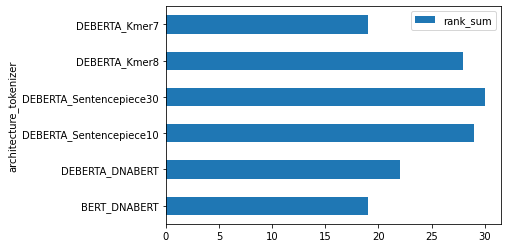

In [32]:
import matplotlib.pyplot as plt

ranks_pretrained.dropna()[['architecture_tokenizer', 'rank_sum']]\
    .plot(kind='barh', x = 'architecture_tokenizer', y = 'rank_sum')

In [33]:
import numpy as np

def do_bar_plot(x, y, name, export):
    # x = ranks_pretrained.dropna()[['architecture_tokenizer']].values
    x = x.values
    x = [item for sublist in x for item in sublist]
    # y = ranks_pretrained.dropna()[['rank_sum']].values
    y = y.values
    y = [item for sublist in y for item in sublist]
    y = [round(x,2) for x in y] 

    fig, ax = plt.subplots() 
    width = 0.75 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width)
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x, minor=False)
    plt.title(name)
    plt.xlabel('sum')
    plt.ylabel('methods') 
    for i, v in enumerate(y):
        ax.text(v + 1, i + .25, str(v), color='blue', fontweight='bold')
    if(export):
        plt.savefig(name + '.png', dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

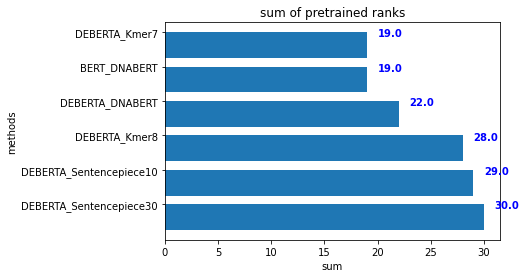

In [34]:
do_bar_plot(
    ranks_pretrained.dropna().sort_values('rank_sum', ascending=False)[['architecture_tokenizer']],
    ranks_pretrained.dropna().sort_values('rank_sum', ascending=False)[['rank_sum']],
    name = 'sum of pretrained ranks',
    export = EXPORT
)

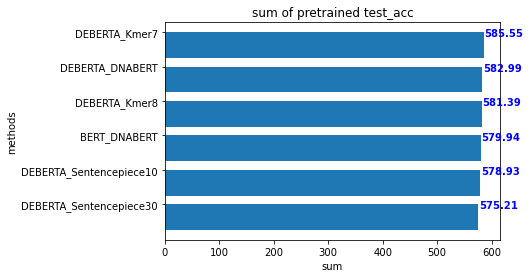

In [35]:
do_bar_plot(
    ranks_pretrained.dropna().sort_values(CHOOSEN_METRIC_PRETRAINED + '_sum')[['architecture_tokenizer']],
    ranks_pretrained.dropna().sort_values(CHOOSEN_METRIC_PRETRAINED + '_sum')[[CHOOSEN_METRIC_PRETRAINED + '_sum']],
    name = 'sum of pretrained ' + CHOOSEN_METRIC,
    export = EXPORT
)


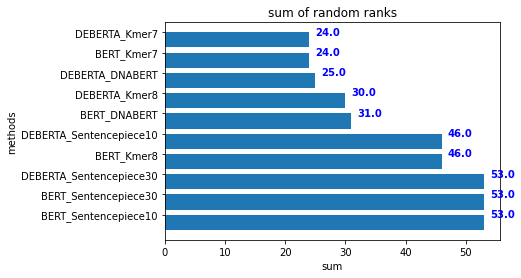

In [36]:
do_bar_plot(
    ranks_both.dropna().sort_values('rank_sum', ascending=False)[['architecture_tokenizer']],
    ranks_both.dropna().sort_values('rank_sum', ascending=False)[['rank_sum']],
    name = 'sum of random ranks',
    export = EXPORT
)

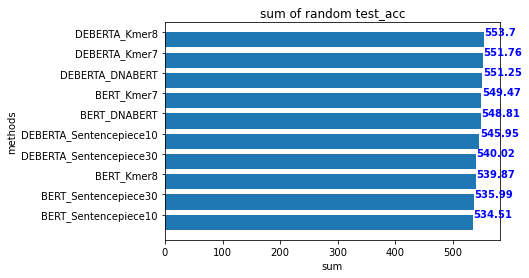

In [37]:
do_bar_plot(
    ranks_both.dropna().sort_values(CHOOSEN_METRIC + '_sum')[['architecture_tokenizer']],
    ranks_both.dropna().sort_values(CHOOSEN_METRIC + '_sum')[[CHOOSEN_METRIC + '_sum']],
    name = 'sum of random ' + CHOOSEN_METRIC,
    export = EXPORT
)

##### Paralel coordinates

In [38]:
import numpy as np
from pandas.plotting import parallel_coordinates

def paralel_fig(name, df, x, export):
    fig = plt.figure()
    fig.set_size_inches(16, 6)

    ax = plt.subplot(111)
    plt.title(name, fontsize=40)

    parallel_coordinates(
        df, 
        x,
        lw = 3
    )

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 16})

    plt.setp(ax.get_xticklabels(), fontsize=16, rotation = 45, fontweight="bold", 
             horizontalalignment="right")

    plt.show()
    if(export):
        plt.savefig(name)

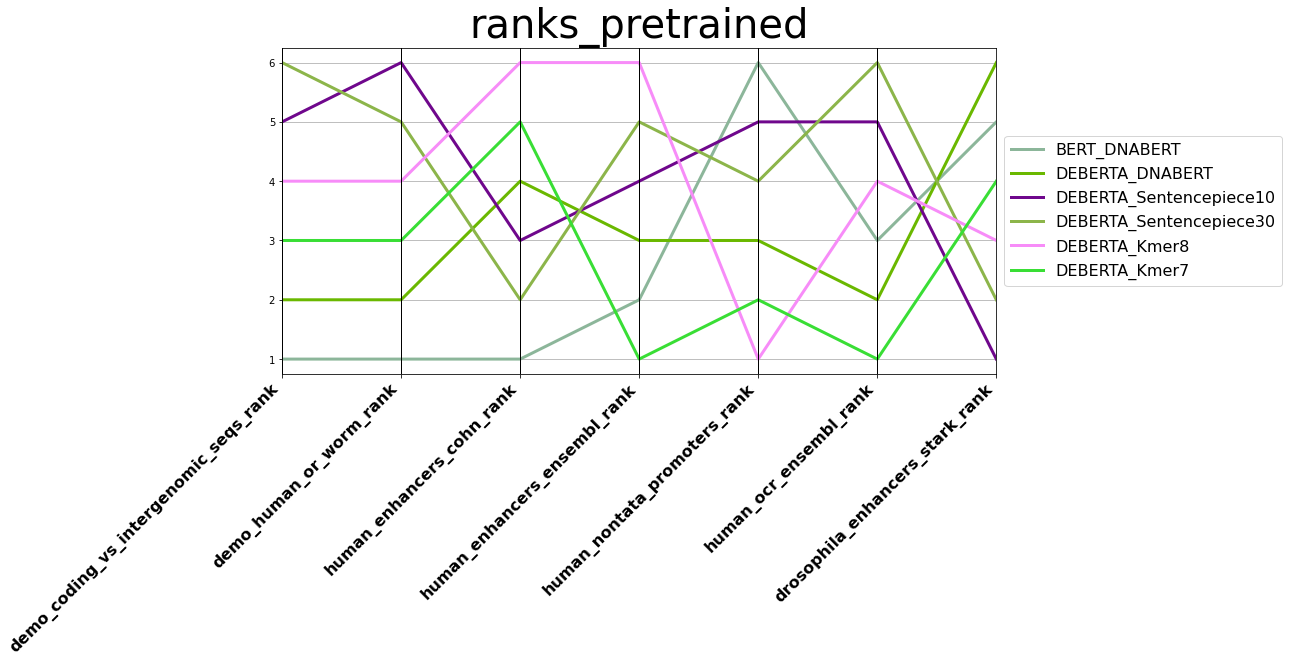

In [39]:

paralel_fig(
    name = 'ranks_pretrained', 
    df = ranks_pretrained.dropna()[['architecture_tokenizer', *choosen_datasets_rank_names]],
    x = 'architecture_tokenizer',
    export = EXPORT
)

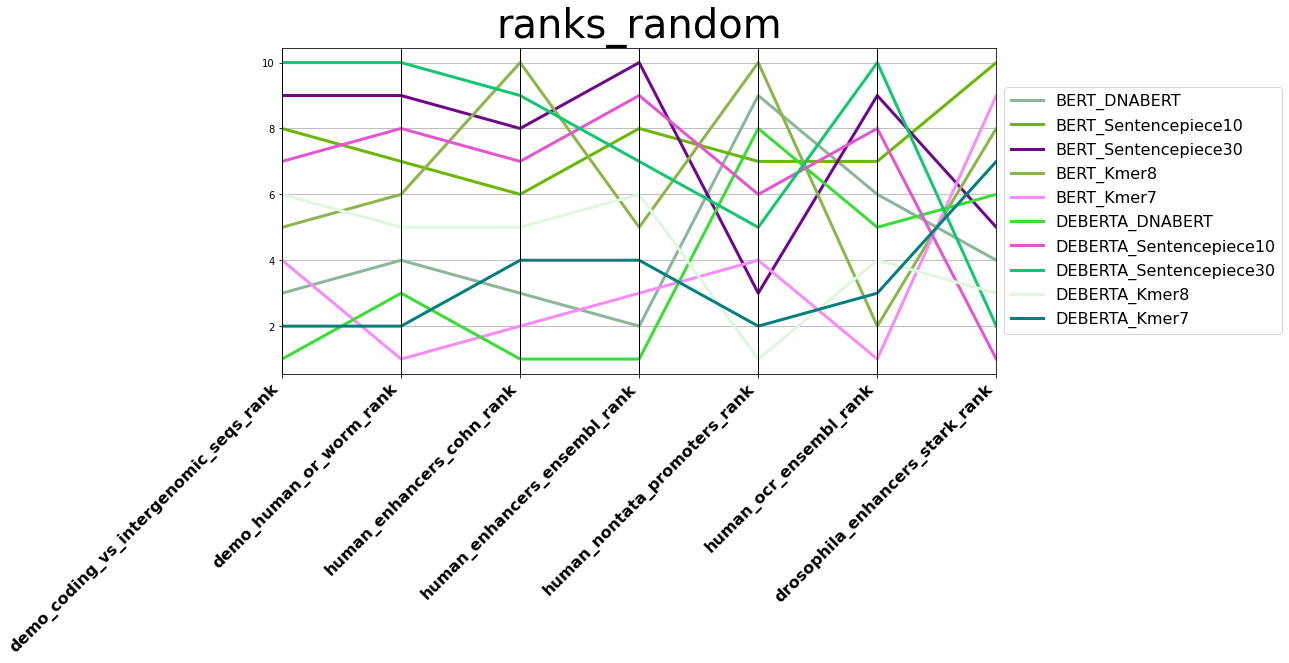

In [40]:
paralel_fig(
    name = 'ranks_random', 
    df = ranks_both.dropna()[['architecture_tokenizer', *choosen_datasets_rank_names]],
    x = 'architecture_tokenizer',
    export = EXPORT
)

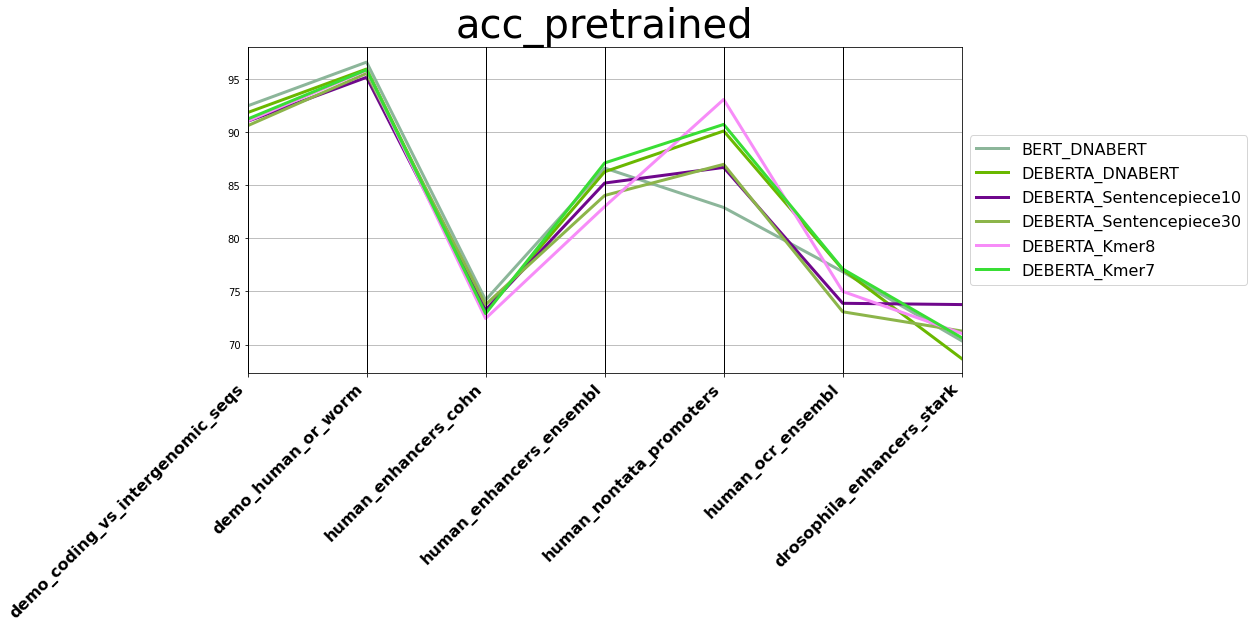

In [41]:
paralel_fig(
    name = 'acc_pretrained', 
    df = results_pretrained.dropna()[['architecture_tokenizer', *exp_options['dataset']]],
    x = 'architecture_tokenizer',
    export = EXPORT
)

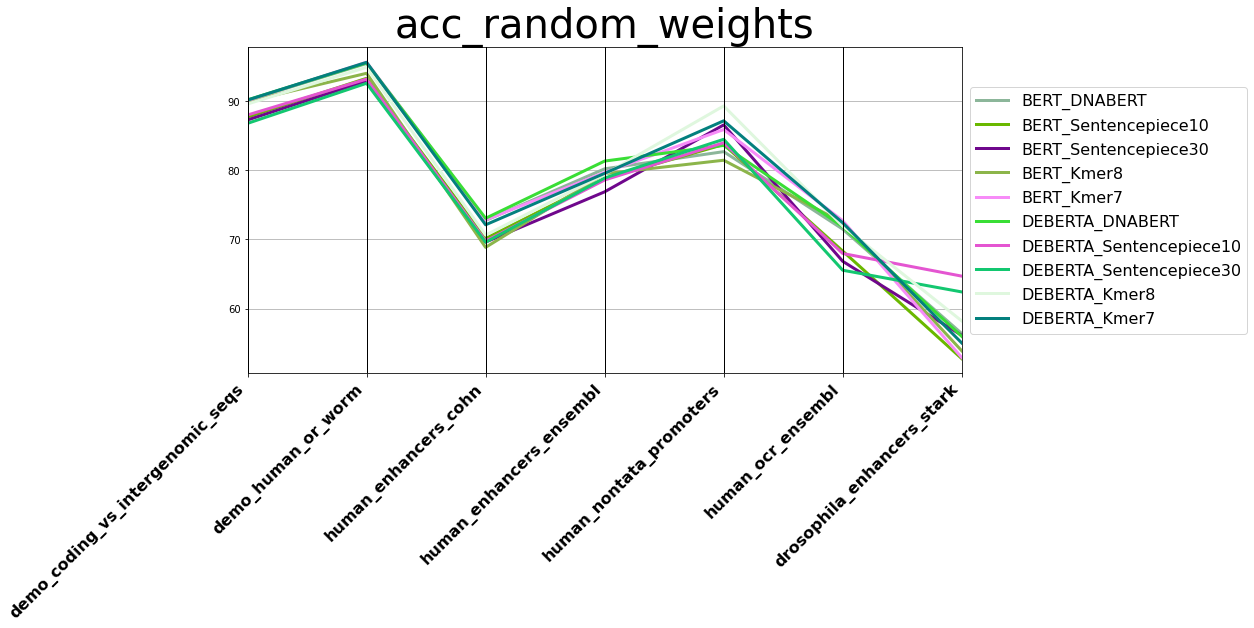

In [42]:
paralel_fig(
    name = 'acc_random_weights', 
    df = results.dropna()[['architecture_tokenizer', *exp_options['dataset']]],
    x = 'architecture_tokenizer',
    export = EXPORT
)